# <center>Исследование данных HR-агенства

Загрузка необходимых библиотек

In [19]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

Загрузка данных

In [15]:
data = pd.read_csv('ds_salaries.csv', index_col=[0])
data.head(5) 

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


### Описательный анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В датасете 607 записей без пропущенных значений

При решении данной задачи корректно оперировать зарплатами, выраженными в одинаковой валюте, а именно, данными столбца *salary_in_usd*. Таким образом, *salary* и *salary_currency* являются неинформативными признаками, удаляем их.

Категориальные признаки *experience_level*, *employment_type*, *employee_residence*, *remote_ratio* и *company_location* не потребуются для ответа на четыре поставленных вопроса, но могут пригодиться при проведении дополнительного анализа. 




In [5]:
# Удаление неинформативных признаков
data = data.drop(['salary', 'salary_currency'], axis = 1)
data.head(2)

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S


Числовым признаком является *salary_in_usd*, остальные - категориальные.

Проверим датасет на наличие дубликатов, при необходимости удалим их.

In [7]:
# Проверка на наличие полных дубликатов
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0])) 
# В данных обнаружено 42 дубликата, удалим их
data = data.drop_duplicates()

Количество дубликатов: 0


Посмотрим на распределение заработных плат по всем сотрудникам. 

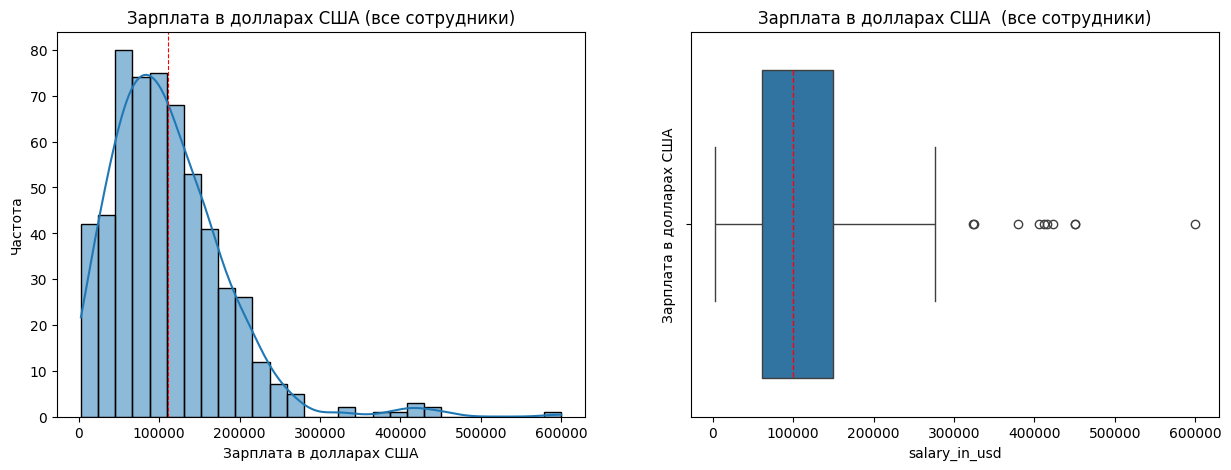

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в долларах США', ylabel='Частота')
axes[0].set_title('Зарплата в долларах США (все сотрудники)')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Зарплата в долларах США')
axes[1].set_title('Зарплата в долларах США  (все сотрудники)')

plt.show()

Диаграммы демонстрируют, что распределение зарплат отлично от нормального, имеются выбросы.

In [12]:
# Выведем также основные статистические характеристики
data_agg = data['salary_in_usd'].describe().round().to_frame()
data_agg.columns = ['Зарплата в долларах США']
data_agg

,Зарплата в долларах США
count,565.0
mean,110610.0
std,72281.0
min,2859.0
25%,60757.0
50%,100000.0
75%,150000.0
max,600000.0


Исследуем признаки "основная страна проживания сотрудника в течение рабочего года" и "страна главного офиса работодателя или филиала по контракту".

In [13]:
# Посмотрим на значения employee_residence
data['employee_residence'].value_counts().head(15)

employee_residence
US    295
GB     43
IN     30
CA     27
DE     24
FR     18
ES     15
GR     12
JP      7
PT      6
BR      6
PK      6
NL      5
PL      4
IT      4
Name: count, dtype: int64

In [14]:
# Посмотрим на значения company_location
data['company_location'].value_counts().head(15)

company_location
US    318
GB     46
CA     28
DE     27
IN     24
FR     15
ES     14
GR     10
JP      6
NL      4
AT      4
PT      4
PL      4
LU      3
PK      3
Name: count, dtype: int64

По странам проживания сотрудников  и cтранам главного офиса работодателя или филиала имеется разное количество данных (для некоторых стран - даннные об одном сотруднике), сложно судить о влиянии данных признаков на заработную плату.

Можно провести дополнительное исследование того, влияет ли совпадение места жительства и расположения офиса компании на заработную плату (т.е. выше ли зарплата, если сотрудник живет в той же стране, где находится офис).

In [11]:
# Удаление признаков 'employee_residence' и 'company_location' на случай, если их влияние на зарпплату далее исследоваться не будет
#data = data.drop(['employee_residence', 'company_location'], axis=1)
#data.head(2)

Построим распределения зарплат Data Scientist по годам. 

*Исследование проводится для роли *Data Scientist*

In [20]:
data['work_year'] = data['work_year'].astype('object')

# Создаем df, содержащий данные только для роли Data Scientist
data_ds = data[data['job_title'] == 'Data Scientist']

fig_1=px.box(data_ds, x = 'salary_in_usd', y = 'work_year', 
             title = 'Распределение заработной платы по годам',
             width = 1000,
             labels = {'salary_in_usd': 'Зарплата в в долларах США', 'work_year': 'Год'}
             )

fig_1.show()
fig_1.write_html('plotly_figures/fig_1.html')

Коробчатую диаграмму распределенй заработной платы специалистов Data_SCientist по годам можно посмотреть [здесь]().

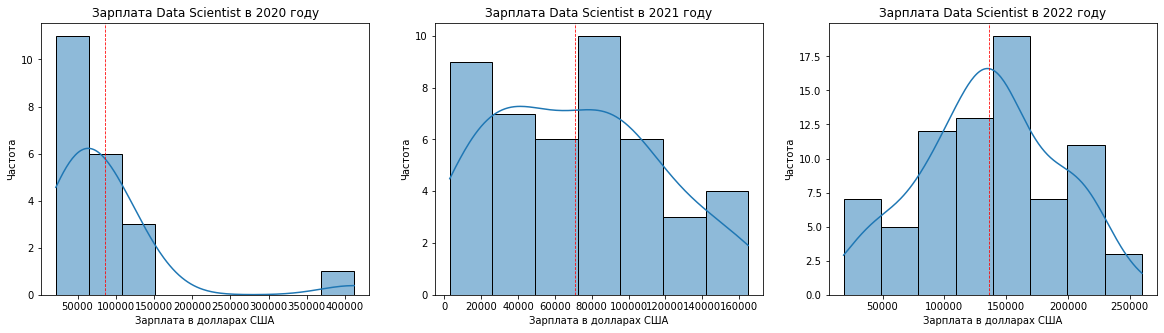

In [14]:
data_2020 = data_ds[data_ds['work_year'] == 2020] 
data_2021 = data_ds[data_ds['work_year'] == 2021] 
data_2022 = data_ds[data_ds['work_year'] == 2022] 

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(data_2020['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в долларах США', ylabel='Частота')
axes[0].set_title('Зарплата Data Scientist в 2020 году')
axes[0].axvline(data_2020['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.histplot(data_2021['salary_in_usd'], kde=True, ax=axes[1])
axes[1].set(xlabel='Зарплата в долларах США', ylabel='Частота')
axes[1].set_title('Зарплата Data Scientist в 2021 году')
axes[1].axvline(data_2021['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.histplot(data_2022['salary_in_usd'], kde=True, ax=axes[2])
axes[2].set(xlabel='Зарплата в долларах США', ylabel='Частота')
axes[2].set_title('Зарплата Data Scientist в 2022 году')
axes[2].axvline(data_2022['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

plt.show()

Распределение зарплат в 2022 году предположительно является нормальным, в 2021 - близко к нормальному, в 2020 - не является. Требуется выполнить проверку на нормальность.

In [15]:
data_year = data_ds.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от года')
data_year

Зарплата в зависимости от года


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.0,62726.0,105000.0,412000.0
2021,45.0,70671.73,45422.97,2859.0,33808.0,73000.0,100000.0,165000.0
2022,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


По 2020 году существенно меньше данных, чем по 2021 и 2022.

### Зарплаты Data Scientist и Data Engineer в 2022 году

In [16]:
# Формируем "сокращенный" датасет
mask =  ((data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')) & (data['work_year'] == 2022) 
data_2022 = data[mask] 

fig_2=px.box(data_2022, x='salary_in_usd', y='job_title', 
             width = 1000,
             labels = {'salary_in_usd': 'Зарплата в долларах США', 'job_title': 'Роль соискателя'},
             title='Зарплата дата-сайентистов и дата-инженеров в 2022 году')
fig_2.show()

По данным диаграммы можно предположить, что зарплата дата-сайентистов выше зарплаты дата-инженеров.

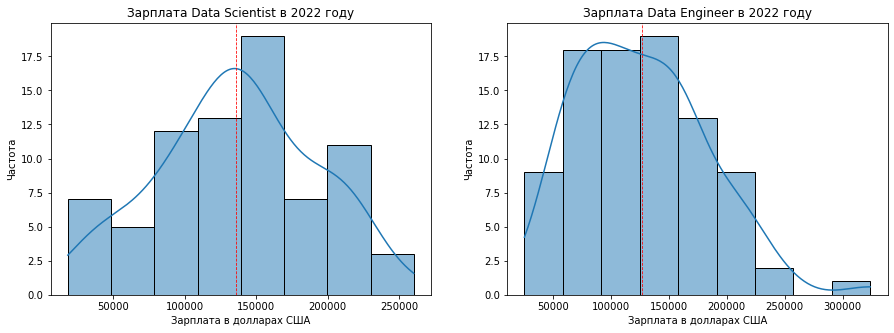

In [17]:
data_2022_ds = data_2022[data_2022['job_title'] == 'Data Scientist'] 
data_2022_de = data_2022[data_2022['job_title'] == 'Data Engineer'] 

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data_2022_ds['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в долларах США', ylabel='Частота')
axes[0].set_title('Зарплата Data Scientist в 2022 году')
axes[0].axvline(data_2022_ds['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.histplot(data_2022_de['salary_in_usd'], kde=True, ax=axes[1])
axes[1].set(xlabel='Зарплата в долларах США', ylabel='Частота')
axes[1].set_title('Зарплата Data Engineer в 2022 году')
axes[1].axvline(data_2022_de['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

plt.show()

Распределение зарплат дата-сайентистов в 2022 году предположительно является нормальным, дата-инженеров - не является нормальным.

In [18]:
data_ds_de = data_2022.groupby('job_title')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от профессии')
data_ds_de

Зарплата в зависимости от профессии


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,89.0,126375.70,55954.40,25000.0,78526.0,120000.0,160000.0,324000.0
Data Scientist,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


### Cоотношение зарплат специалистов Data Scientist в компаниях различных размеров
Анализ проводится для роли *Data Scientist*

In [19]:
fig_3 = px.box(data_ds, x='salary_in_usd', y='company_size', title='Зарплата в компаниях различных размеров',
               labels = {'salary_in_usd': 'Зарплата в долларах США', 'company_size': 'Размер компании'},
               category_orders={'company_size':['S', 'M', 'L']})
fig_3.show()

По данным диаграммы можно предположить, что наименьшая заработная плата специалистов *Data Scientist* - в небольших компаниях, наибольшая - в средних. 

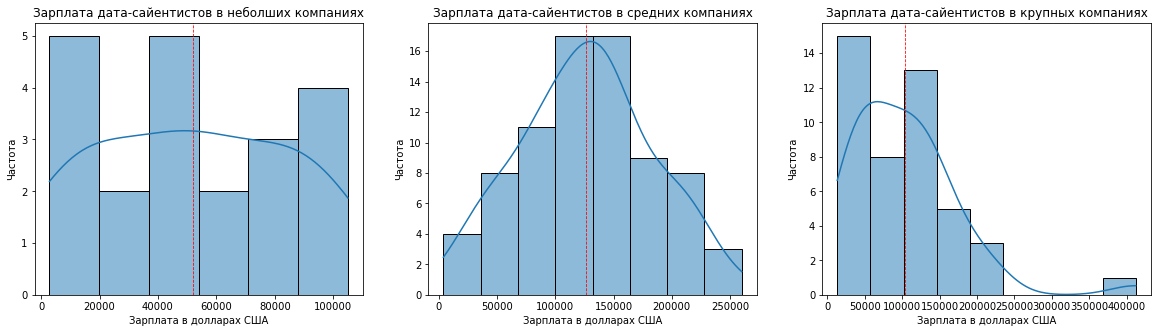

In [20]:
data_s = data_ds[data_ds['company_size'] == 'S'] 
data_m = data_ds[data_ds['company_size'] == 'M'] 
data_l = data_ds[data_ds['company_size'] == 'L'] 

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(data_s['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в долларах США', ylabel='Частота')
axes[0].set_title('Зарплата дата-сайентистов в неболших компаниях')
axes[0].axvline(data_s['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.histplot(data_m['salary_in_usd'], kde=True, ax=axes[1])
axes[1].set(xlabel='Зарплата в долларах США', ylabel='Частота')
axes[1].set_title('Зарплата дата-сайентистов в средних компаниях')
axes[1].axvline(data_m['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.histplot(data_l['salary_in_usd'], kde=True, ax=axes[2])
axes[2].set(xlabel='Зарплата в долларах США', ylabel='Частота')
axes[2].set_title('Зарплата дата-сайентистов в крупных компаниях')
axes[2].axvline(data_l['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

plt.show()

Распределение зарплат в средних компаниях является нормальным, в крупных - не является, в небольших компаниях близко к нормальному, требуется выполнить проверку.

In [21]:
data_company_size = data_ds.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Зарплата в компаниях различных размеров')
data_company_size

Зарплата в компаниях различных размеров


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,45.0,103313.36,71815.18,13400.0,50000.0,90734.0,135000.0,412000.0
M,77.0,126380.75,56389.53,4000.0,90000.0,130000.0,165000.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


По небольшим компаниям имеется значительно меньше данных (почти в 4 раза меньше, чем по средним).

### Исследование связи между наличием должностей Data Scientist и Data Engineer и размером компании
В данных нет столбца типа "id компании", поэтому нет возможности выяснить, могут ли относиться несколько строк к разным специалистам одной и той же компании. Например, если имеются данные о специалисте Machine Learning Scientist некоторой компании, невозможно проверить, есть ли в той же компании специалисты Data Engineer.

In [23]:
# Посмотрим на содержание столбца job_title
data['job_title'].value_counts().head(15)

Data Scientist                143
Data Engineer                 132
Data Analyst                   97
Machine Learning Engineer      41
Research Scientist             16
Data Science Manager           12
Data Architect                 11
Big Data Engineer               8
Machine Learning Scientist      8
Principal Data Scientist        7
AI Scientist                    7
Data Science Consultant         7
Director of Data Science        7
Data Analytics Manager          7
ML Engineer                     6
Name: job_title, dtype: int64

Data Scientist и Data Engineer являются наиболее популярными ролями.

In [25]:
# Хотим посмотреть, какой процент среди всех специалистов компаний определенного размера составляют DS и DE

# Создаем df, содержащий столбцы 'company_size' и 'job_title'
data_job_title = data[['company_size', 'job_title']].copy()
data_job_title.head(5)
# Формируем датафрейм с количеством разных ролей по размерам компаний
data_job_title = data_job_title.groupby(by=['company_size', 'job_title'])['job_title'].count().unstack()  

# Добавляем столбец с суммарным количеством разных специалистов в компании данного размера (сумма по строке)
data_job_title['sum_all'] = data_job_title.sum(axis=1)

#Оставляем столбцы с интересующими нас ролями
data_job_title = data_job_title[['Data Scientist', 'Data Engineer', 'sum_all']].copy()

#Добавим столбцы с долями интересующих нас профессий из общего числа строк данного размера компании (в процентах)
data_job_title['DS_proportion'] =  (data_job_title['Data Scientist']/data_job_title['sum_all']*100).round(1)
data_job_title['DE_proportion'] =  (data_job_title['Data Engineer']/data_job_title['sum_all']*100).round(1)

# Оставляем только столбцы с процентами
data_job_title = data_job_title.drop(['Data Scientist', 'Data Engineer', 'sum_all'], axis =1)

display(data_job_title)

fig_4=px.bar(data_job_title,
             barmode = 'group', 
             labels = {'company_size': 'Размер компании', 'value': 'Доля среди всех специалистов, %'},
             title = 'Процент ролей Data Scientist и Data Engineer среди всех вакансий компаний различного размера'
)
fig_4.show()

job_title,DS_proportion,DE_proportion
company_size,,
L,22.7,18.7
M,23.6,27.3
S,25.3,7.2


В компаниях всех размеров примерно четверть ролей - дата-сайентисты.\
В крупных и средних компаниях дата-инженеров, соответственно, порядка 19 и 24%. В небольших компаниях дата-инженеров существенно меньше (около 7% всех ролей).\
Таким образом, связь между размером компании и наличием ролей наблюдается в большей степени для дата-инженеров: их доля в крупных и средних компаниях существенно выше, чем в небольших.

### Исследование влияния других признаков на заработную плату

#### Влияние типа трудоустройства

In [25]:
fig_5=px.box(data, x='salary_in_usd', y='employment_type', 
             title='Распределение заработной платы в зависимости от типа трудоустройства')
fig_5.show()


In [26]:
data_employment_type = data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Зарплата при различном типе трудоустройства')
data_employment_type

Зарплата при различном типе трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
CT,5.0,184575.00,156250.89,31875.0,100000.00,105000.0,270000.0,416000.0
FL,4.0,48000.00,40529.82,12000.0,18000.00,40000.0,70000.0,100000.0
FT,588.0,113468.07,69476.47,2859.0,64962.25,104196.5,150000.0,600000.0
PT,10.0,33070.50,31472.91,5409.0,12000.00,18817.5,48370.0,100000.0


Самая маленькая зарплата у специалистов с типом трудоустройства "неполный рабочий день" (PT), несколько выше - у фрилансеров (FL), еще выше - у специалистов, работающих по графику "полный рабочий день" (FT), однако среди них есть несколько специалистов с самой высокой зарплатой по базе данных. Наиболее высокие зарплаты - у контрактников (CT). Однако данных по всем типам трудоустройства кроме "полный рабочий день" очень мало и может быть недостаточно, чтобы провести корректный сравнительный анализ. \
Основной вывод: подавляющее большинство специалистов работают по графику "полный рабочий день".

#### Влияние опыта работы на этой должности в течение года

In [26]:
fig_6=px.box(data, x='salary_in_usd', y='experience_level', 
             title='Распределение заработной платы в зависимости от опыта работы на этой должности в течение года ',
             category_orders={'experience_level':['EN', 'MI', 'SE', 'EX']}
             )
fig_6.show()

Чем в более высокой должости работал сотрудник, тем выше его зарплата.

#### Влияние общего объёма работы, выполняемой удалённо

In [27]:
data['remote_ratio'] = data['remote_ratio'].astype('object')

fig_7=px.box(data, x='salary_in_usd', y='remote_ratio', 
             title='Распределение заработной платы в зависимости от общего объёма работы, выполняемой удалённо'
             )
fig_7.show()

Визуально явная зависимость заработной платы от объема работы, выполняемой удаленно, не прослеживается. 

#### Влияние удаленности головного офиса или филиала от места проживания сотрудника

In [35]:
# Создадим признак "location_coincidence"
x = lambda a,b: 1 if a==b else 0
data['location_coincidence'] = data.apply(lambda row: x(row['company_location'], row['employee_residence']), axis=1)
display(data.head(2))

data['location_coincidence'].value_counts()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,location_coincidence
0,0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L,1
1,1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S,1


1    556
0     51
Name: location_coincidence, dtype: int64

Сотрудников, не проживающих в стране расположения головного офиса или филиала, менее 10%

In [38]:
data['location_coincidence'] = data['location_coincidence'].astype('object')

fig_8=px.box(data, x='salary_in_usd', y='location_coincidence', 
             title='Распределение заработной платы в зависимости от общего объёма работы, выполняемой удалённо'
             )
fig_8.show()

Можно предположить, что зарплата сотрудников, проживающих в стране расположения головного офиса или филиала компании, выше.

## Статистический аназиз данных
Исследуемый признак *salary_in_usd* является числовым, поэтому для проведения статистического анализа будем применять статистические тесты для числовых признаков.

In [ ]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

При проведении некоторых статистических тестов будем использовать другой уровень значимости. 

In [39]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы c возможностью изменения уровня значимости
def decision_hypothesis(p, alpha_add):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha_add:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha_add))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha_add))

### Наблюдается ли годовой рост зарплат у специалистов Data Scientist?

Отвечаем на вопрос именно для роли *Data Scientist*.

Имеется три выборки разной длины: зарплаты за  2020 ($μ_1$), 2021 ($μ_2$) и 2022 ($μ_3$) годы. 

Так как нас интересует не только равенство, но и направление изменения зарплат от года к году (растет или уменьшается), будем выполнять статистический анализ попарно для 2020 и 2021, 2021 и 2022 годов.

##### Проверка на нормальность (тест Шапиро-Уилка)

In [31]:
salaries_2020 = data.loc[(data['work_year'] == 2020) & (data['job_title'] == 'Data Scientist'), 'salary_in_usd']
salaries_2021 = data.loc[(data['work_year'] == 2021) & (data['job_title'] == 'Data Scientist'), 'salary_in_usd']
salaries_2022 = data.loc[(data['work_year'] == 2022) & (data['job_title'] == 'Data Scientist'), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2020 года:')
print('Группа содержит', salaries_2020.shape[0],  'значений')
result = stats.shapiro(salaries_2020)
decision_normality(result[1])
print()

print('Для 2021 года:')
print('Группа содержит', salaries_2021.shape[0],  'значений')
result = stats.shapiro(salaries_2022)
decision_normality(result[1])
print()

print('Для 2022 года:')
print('Группа содержит', salaries_2022.shape[0],  'значений')
result = stats.shapiro(salaries_2022)
decision_normality(result[1])

Для 2020 года:
Группа содержит 21 значений
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для 2021 года:
Группа содержит 45 значений
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для 2022 года:
Группа содержит 77 значений
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


##### Проверка того, что зарплата в 2021 году по сравнению с 2020 годом изменилась:
*Нулевая гипотеза*: средние зарплаты специалистов в 2020 и 2021 годах одинаковы.
$$ H_0: μ_2=μ_1$$
*Альтернативная гипотеза*: средние зарплаты специалистов в 2020 и 2021 годах не одинаковы.
$$ H_1: μ_2 \neq μ_1 $$

Две группы являются независимыми, не все распределения являются нормальными. Применяем U-критерий Манна-Уитни.

In [32]:
# проводим тест на сравнение средних в группах
print('Для 2021 и 2020 годов:')
_, p = stats.mannwhitneyu(salaries_2021, salaries_2020) #, alternative='less')
decision_hypothesis(p, alpha)

Для 2021 и 2020 годов:
p-value = 0.640
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


##### Проверка того, что зарплата в 2022 году выросла по сравнению с 2021 годом:
*Нулевая гипотеза*: средняя зарплата специалистов в 2022 году меньше или равна средней зарплате в 2021.
$$ H_0: μ_3<=μ_2$$
*Альтернативная гипотеза*: средняя зарплата специалистов в 2022 году больше средней зарплаты в 2021.
$$ H_1: μ_3 > μ_2 $$

Две группы являются независимыми, оба распределения являются нормальными. Применяем двухвыборочный t-критерий (t-test). 

In [33]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(salaries_2022, salaries_2021)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.445
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


In [34]:
# проводим тест на сравнение средних в группах
_, p = stats.ttest_ind(salaries_2022, salaries_2021, alternative='greater', equal_var=True)
decision_hypothesis(p, alpha)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


*Вывод:* 
 - Нет оснований утверждать, что зарплата специалистов Data Scientist изменилась в 2021 году по сравнению с 2020.
 - Зарплата специалистов Data Scientist в 2022 году выросла по сравнению с 2021.

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

Визуализация позволяет предположить, что зарплата дата-сайентистов в 2022 году была выше зарплаты дата-инженеров.

*Нулевая гипотеза*: в 2022 году средняя зарплата дата-сайентистов ($μ_1$) меньше или равна средней зарплате дата-инженеров ($μ_2$).
$$ H_0: μ_1<=μ_2$$
*Альтернативная гипотеза*: в 2022 году средняя зарплата дата-сайентистов больше средней зарплаты дата-инженеров.
$$ H_1: μ_1 > μ_2 $$


##### Проверка на нормальность (тест Шапиро-Уилка)

In [35]:
salaries_ds = data.loc[(data['work_year'] == 2022) & (data['job_title'] == 'Data Scientist'), 'salary_in_usd']
salaries_de = data.loc[(data['work_year'] == 2022) & (data['job_title'] == 'Data Engineer'), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для дата-сайентистов:')
print('Группа содержит', salaries_ds.shape[0],  'значений')
result = stats.shapiro(salaries_ds)
decision_normality(result[1])
print()

print('Для дата-инженеров:')
print('Группа содержит', salaries_de.shape[0],  'значений')
result = stats.shapiro(salaries_de)
decision_normality(result[1])

Для дата-сайентистов:
Группа содержит 77 значений
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для дата-инженеров:
Группа содержит 89 значений
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Результаты применения теста Шапиро-Уилка подтверждают выводы, сделанные на основе визуализации распределений зарплат. 

Две группы являются независимыми, не все распределения являются нормальными. Применяем  U-критерий Манна-Уитни.

In [37]:
# проводим тест на сравнение средних в группах с уровнями значимости 0.05 и 0.1
_, p = stats.mannwhitneyu(salaries_ds, salaries_de, alternative='greater')
decision_hypothesis(p, alpha)
print()
decision_hypothesis(p, 0.1)

p-value = 0.077
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.

p-value = 0.077
p-значение меньше, чем заданный уровень значимости 0.10. Отвергаем нулевую гипотезу в пользу альтернативной.


Выяснили, что зарплата Data Scientist меньше или равна зарплате Data Engineer c уровнем значимости 0.05.
#### Проверим гипотезу о равенстве зарплат.
*Нулевая гипотеза*: в 2022 году средняя зарплата дата-сайентистов ($μ_1$)  равна средней зарплате дата-инженеров ($μ_2$).
$$ H_0: μ_1=μ_2$$
*Альтернативная гипотеза*: в 2022 году средняя зарплата дата-сайентистов не равна средней зарплате дата-инженеров.
$$ H_1: μ_1 \neq μ_2 $$



In [38]:
# проводим тест на сравнение средних в группах
_, p = stats.mannwhitneyu(salaries_ds, salaries_de) 
decision_hypothesis(p, alpha)

p-value = 0.155
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Проверим гипотезу о равенстве зарплат с применением критерия Краскела-Уоллиса.

In [39]:
_, p = stats.kruskal(salaries_ds, salaries_de)
decision_hypothesis(p, alpha)

p-value = 0.154
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


*Вывод:* Нет оснований утверждать об отличии зарплат специалистов Data Scientist и Data Engineer в 2022 году.

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

*Нулевая гипотеза*: средняя зарплата Data Scientist в крупных, средних и небольших компаниях одинакова.
$$ H_0: μ_1 = μ_2 = μ_3 $$
*Альтернативная гипотеза*: средняя зарплата Data Scientist в крупных, средних и небольших компаниях отличается.
$$ H_1: μ_1 \neq μ_2 \neq μ_3 $$

##### Проверка на нормальность (тест Шапиро-Уилка)

In [41]:
salaries_s = data.loc[(data['company_size'] == 'S') & (data['job_title'] == 'Data Scientist'), 'salary_in_usd']
salaries_m = data.loc[(data['company_size'] == 'M') & (data['job_title'] == 'Data Scientist'), 'salary_in_usd']
salaries_l = data.loc[(data['company_size'] == 'L') & (data['job_title'] == 'Data Scientist'), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для небольших компаний:')
print('Группа содержит', salaries_s.shape[0],  'значений')
result = stats.shapiro(salaries_s)
decision_normality(result[1])
print()

print('Для средних компаний:')
print('Группа содержит', salaries_m.shape[0],  'значений')
result = stats.shapiro(salaries_m)
decision_normality(result[1])
print()

print('Для крупных компаний:')
print('Группа содержит', salaries_l.shape[0],  'значений')
result = stats.shapiro(salaries_l)
decision_normality(result[1])
print()

Для небольших компаний:
Группа содержит 21 значений
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для средних компаний:
Группа содержит 77 значений
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для крупных компаний:
Группа содержит 45 значений
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального



Три группы являются независимыми, не все распределения являются нормальными. Применяем критерий Краскела-Уоллиса.

In [42]:
_, p = stats.kruskal(salaries_s, salaries_m, salaries_l)
decision_hypothesis(p, alpha)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Для получения более точной информации сравним зарплаты в компаниях разного размера попарно.

Сравним зарплаты в небольших и крупных компаниях.

*Нулевая гипотеза*: средняя зарплата Data Scientist в небольших компаниях больше или равна зарплате в крупных.
$$ H_0: μ_1 >= μ_3 $$
*Альтернативная гипотеза*: средняя зарплата Data Scientist в небольших компаниях меньше зарплаты в крупных.
$$ H_1: μ_1 < μ_3 $$


Две выборки независимы, не все распределения являются нормальными. Применяем U-критерий Манна-Уитни.

In [43]:
_, p = stats.mannwhitneyu(salaries_s, salaries_l, alternative = 'less')
decision_hypothesis(p, alpha)

p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Сравним зарплаты в крупных и средних компаниях.

*Нулевая гипотеза*: средняя зарплата Data Scientist в крупных компаниях больше или равна зарплате в средних.
$$ H_0: μ_3 >= μ_2 $$
*Альтернативная гипотеза*: средняя зарплата Data Scientist в крупных компаниях меньше зарплаты в средних.
$$ H_1: μ_3 < μ_2 $$

Две выборки независимы, не все распределения являются нормальными. Применяем U-критерий Манна-Уитни.

In [44]:
_, p = stats.mannwhitneyu(salaries_l, salaries_m, alternative = 'less')
decision_hypothesis(p, alpha)

p-value = 0.006
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


*Вывод:* Наиболее высокие заработные платы - у специалистов Data Scientist в средних компаниях, наиболее низкие - в небольших компаниях.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

In [45]:
# Cоздадим df c информацией только о двух рассматриваемых ролях
data_ds_de = data[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')]

# Построим таблицу сопряженности
table = pd.crosstab(data_ds_de['company_size'], data_ds_de['job_title'])
print('Таблица сопряженности признаков company_size и job_title')
table

Таблица сопряженности признаков company_size и job_title


job_title,Data Engineer,Data Scientist
company_size,,
L,37,45
M,89,77
S,6,21


*Нулевая гипотеза*: связь между наличием должностей Data Scientist и Data Engineer и размером компании отсутствует.\
*Альтернативная гипотеза*: связь между наличием должностей Data Scientist и Data Engineer и размером компании присутствует.


В каждой ячейке таблицы сопряженности более 5 элементов, применим критерий хи-квадрат.

In [46]:
_, p, _, _ = stats.chi2_contingency(table)
decision_hypothesis(p, alpha)

p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


*Вывод:* Связь между наличием должностей Data Scientist и Data Engineer и размером компании присутствует.

### Дополнительные исследования

##### Проверим, влияет ли объем работы, выполняемой удаленно, на заработную плату (для всех специалистов, представленных в базе данных).

Имеется три независимых группы: удалённой работы нет ($μ_1$);  частично удалённая работа ($μ_2$) ; полностью удалённая работа ($μ_3$).

*Нулевая гипотеза*: при различном объеме работы, выполняемой удаленно, заработная плата остается одинаковой.
$$ H_0: μ_1 = μ_2 = μ_3 $$
*Альтернативная гипотеза*: при различном объеме работы, выполняемой удаленно, заработная плата различается.
$$ H_1: μ_1 \neq μ_2 \neq μ_3  $$


##### Проверка на нормальность (тест Шапиро-Уилка)

In [47]:
salaries_0   = data.loc[(data['remote_ratio'] == 0),  'salary_in_usd']
salaries_50  = data.loc[(data['remote_ratio'] == 50), 'salary_in_usd']
salaries_100 = data.loc[(data['remote_ratio'] == 100),'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Удаленной работы нет:')
print('Группа содержит', salaries_0.shape[0], 'значений')
result = stats.shapiro(salaries_0)
decision_normality(result[1])
print()

print('Частично удаленная работа:')
print('Группа содержит', salaries_50.shape[0], 'значений')
result = stats.shapiro(salaries_50)
decision_normality(result[1])
print()

print('Полностью удаленная работа:')
print('Группа содержит', salaries_100.shape[0], 'значений')
result = stats.shapiro(salaries_100)
decision_normality(result[1])
print()

Удаленной работы нет:
Группа содержит 127 значений
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Частично удаленная работа:
Группа содержит 99 значений
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Полностью удаленная работа:
Группа содержит 381 значений
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального



Три группы независимы, все распределения отличны от нормального. Применяем критерий Краскела-Уоллиса. 

In [48]:
_, p = stats.kruskal(salaries_0, salaries_50, salaries_100)
decision_hypothesis(p, alpha)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


*Вывод:* Объем работы, выполняемой удаленно, оказывает влияние на заработную плату.

##### Проверим, влияет ли проживание в стране, отличной от страны расположения головного офиса или филиала компании, на заработную плату
*Нулевая гипотеза*: зарплата сотрудников, проживающих в стране расположения головного офиса или филиала компании ($μ_1$) меньше или равна зарплате сотрудников, проживающих в другой стране ($μ_2$).
$$ H_0: μ_1 <= μ_2 $$
*Альтернативная гипотеза*: зарплата сотрудников, проживающих в стране расположения головного офиса или филиала компании больше зарплаты сотрудников, проживающих в другой стране.
$$ H_1: μ_1 > μ_2 $$

##### Проверка на нормальность (тест Шапиро-Уилка)

In [40]:
salaries_near = data.loc[(data['location_coincidence'] == 1),  'salary_in_usd']
salaries_far = data.loc[(data['location_coincidence'] == 0), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Одна страна:')
print('Группа содержит', salaries_near.shape[0], 'значений')
result = stats.shapiro(salaries_near)
decision_normality(result[1])
print()

print('Разные страны:')
print('Группа содержит', salaries_far.shape[0], 'значений')
result = stats.shapiro(salaries_far)
decision_normality(result[1])
print()

Одна страна:
Группа содержит 556 значений
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Разные страны:
Группа содержит 51 значений
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального



Группы независимы, распределения отличны от нормального. Применяем U-критерий Манна-Уитни.

In [46]:
_, p = stats.mannwhitneyu(salaries_near, salaries_far, alternative = 'greater')
decision_hypothesis(p, alpha)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


*Вывод:* Зарплата сотрудников, проживающих в стране расположения головного офиса или филиала компании больше зарплаты сотрудников, проживающих в другой стране.

### Выводы
 - Рост зарплат Data Scientist в 2021 году по сравнению с 2020 годом не наблюдается. Следует отметить, что выборка зарплат Data Scientist в 2020 году является малой по сравнению с данными для 2021 и 2022 годов и может не совсем объективно характеризовать общий уровень зарплат в соответствующем периоде. Установлено, что в 2022 году зарплаты Data Scientist были выше по сравнению с 2021 годом.
   
 - С уровнем значимости 0.05 нет оснований утверждать, что есть разница в зарплатах Data Scientist и Data Engineer в 2022 году.

 - Наиболее высокие заработные платы - у специалистов Data Scientist в средних компаниях, наиболее низкие - в небольших компаниях.
 - Cвязь между наличием должностей Data Scientist и Data Engineer и размером компании присутствует. 

 - Объем работы, выполняемой удаленно, оказывает влияние на размер заработной платы специалистов.
 - Зарплата специалистов, проживающих в стране головного офиса или филиала компании, выше, чем у специалистов, проживающих в другой стране.  